In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Conv2D,BatchNormalization,MaxPooling2D,Flatten,Dense,Dropout

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

lgg-mri-segmentation.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile
zip = zipfile.ZipFile('/content/lgg-mri-segmentation.zip')
zip.extractall('/content')
zip.close()

In [ ]:
data_path = '/content/lgg-mri-segmentation/kaggle_3m'

In [ ]:
data_path

'/content/lgg-mri-segmentation/kaggle_3m'

In [ ]:
data = pd.read_csv('/content/lgg-mri-segmentation/kaggle_3m/data.csv')

In [ ]:
data.head()

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,NaN,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,NaN,0.0
3,TCGA_CS_4944,NaN,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,NaN,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,NaN,0.0


In [ ]:
import os
dirs = []
images = []
masks = []
for dirname, _, filenames in os.walk(data_path):
    for filename in filenames:
        if 'mask'in filename:
            dirs.append(dirname.replace(data_path,''))
            masks.append(filename)
            images.append(filename.replace('_mask', ''))

In [ ]:
print(masks[:10], images[:10])

['TCGA_CS_4944_20010208_2_mask.tif', 'TCGA_CS_4944_20010208_9_mask.tif', 'TCGA_CS_4944_20010208_15_mask.tif', 'TCGA_CS_4944_20010208_16_mask.tif', 'TCGA_CS_4944_20010208_6_mask.tif', 'TCGA_CS_4944_20010208_13_mask.tif', 'TCGA_CS_4944_20010208_19_mask.tif', 'TCGA_CS_4944_20010208_12_mask.tif', 'TCGA_CS_4944_20010208_17_mask.tif', 'TCGA_CS_4944_20010208_4_mask.tif'] ['TCGA_CS_4944_20010208_2.tif', 'TCGA_CS_4944_20010208_9.tif', 'TCGA_CS_4944_20010208_15.tif', 'TCGA_CS_4944_20010208_16.tif', 'TCGA_CS_4944_20010208_6.tif', 'TCGA_CS_4944_20010208_13.tif', 'TCGA_CS_4944_20010208_19.tif', 'TCGA_CS_4944_20010208_12.tif', 'TCGA_CS_4944_20010208_17.tif', 'TCGA_CS_4944_20010208_4.tif']


In [ ]:
len(dirs), len(images), len(masks)

(3929, 3929, 3929)

In [ ]:
df=pd.DataFrame({'Directory':dirs,'Images':images,'Masks':masks})

In [ ]:
df.head()

,Directory,Images,Masks
0,/TCGA_CS_4944_20010208,TCGA_CS_4944_20010208_2.tif,TCGA_CS_4944_20010208_2_mask.tif
1,/TCGA_CS_4944_20010208,TCGA_CS_4944_20010208_9.tif,TCGA_CS_4944_20010208_9_mask.tif
2,/TCGA_CS_4944_20010208,TCGA_CS_4944_20010208_15.tif,TCGA_CS_4944_20010208_15_mask.tif
3,/TCGA_CS_4944_20010208,TCGA_CS_4944_20010208_16.tif,TCGA_CS_4944_20010208_16_mask.tif
4,/TCGA_CS_4944_20010208,TCGA_CS_4944_20010208_6.tif,TCGA_CS_4944_20010208_6_mask.tif


In [ ]:
def handle(x):
  if x[0]=='/':
    return x[1:]

In [ ]:
df['Directory'] = df['Directory'].apply(handle)

In [ ]:
df.head()

,Directory,Images,Masks
0,TCGA_CS_4944_20010208,TCGA_CS_4944_20010208_2.tif,TCGA_CS_4944_20010208_2_mask.tif
1,TCGA_CS_4944_20010208,TCGA_CS_4944_20010208_9.tif,TCGA_CS_4944_20010208_9_mask.tif
2,TCGA_CS_4944_20010208,TCGA_CS_4944_20010208_15.tif,TCGA_CS_4944_20010208_15_mask.tif
3,TCGA_CS_4944_20010208,TCGA_CS_4944_20010208_16.tif,TCGA_CS_4944_20010208_16_mask.tif
4,TCGA_CS_4944_20010208,TCGA_CS_4944_20010208_6.tif,TCGA_CS_4944_20010208_6_mask.tif


In [ ]:
import cv2

In [ ]:
df['Directory'][0]

'TCGA_CS_4944_20010208'

Finding the shape of the image:

To get the shape, we need to followthe path of the path of the image

In [ ]:
def shape():
  random_id = np.random.randint(0,len(dirs)-1)
  image_path = os.path.join(data_path,df['Directory'].iloc[random_id],df['Images'].iloc[random_id])
  mask_path = os.path.join(data_path,df['Directory'].iloc[random_id],df['Masks'].iloc[random_id])
  print(mask_path)
  image = cv2.imread(image_path)
  mask = cv2.imread(mask_path)
  print(np.max(mask))
  # print(mask)
  # print(image.shape)
  # print(mask.shape)

In [ ]:
for i in range(5):
  shape()

/content/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_10_mask.tif
0
/content/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_4_mask.tif
0
/content/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_14_mask.tif
0
/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_24_mask.tif
255
/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_31_mask.tif
0


In [ ]:
def plot_images():
  random_id = np.random.randint(0,len(dirs)-1)
  image_path = os.path.join(data_path,df['Directory'].iloc[random_id],df['Images'].iloc[random_id])
  mask_path = os.path.join(data_path,df['Directory'].iloc[random_id],df['Masks'].iloc[random_id])
  image = cv2.imread(image_path)
  mask = cv2.imread(mask_path)
  fig,axis=plt.subplots(1,3,figsize=(15,13))
  axis[0].imshow(image)
  axis[0].set_title('Brain MRI')

  axis[1].imshow(mask)
  axis[1].set_title('Mask')

  axis[2].imshow(image)
  axis[2].imshow(mask,alpha=.4)
  axis[2].set_title('MRI with Mask')

  plt.grid(False)
  plt.show()

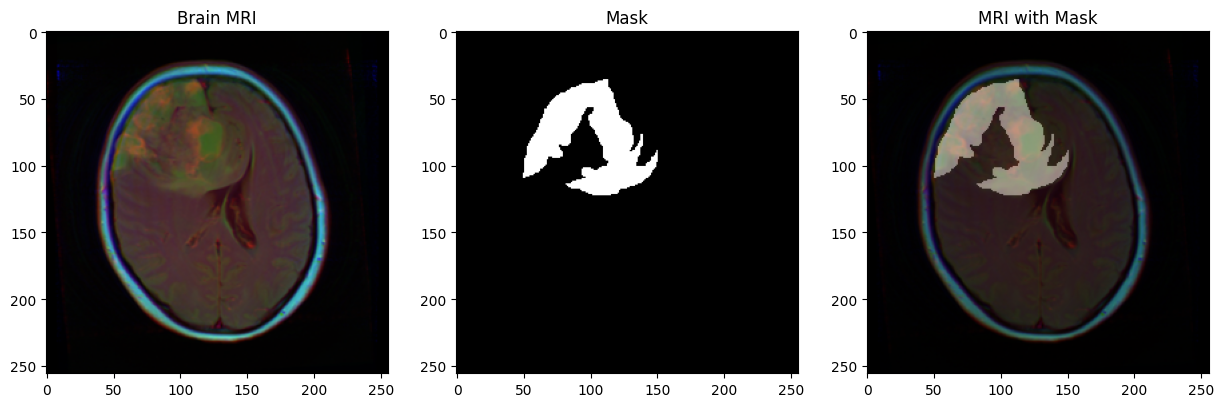

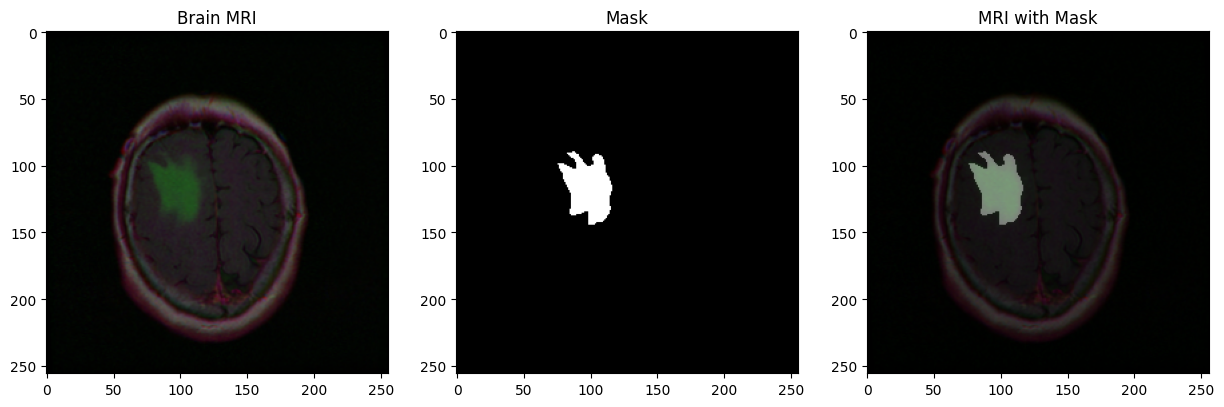

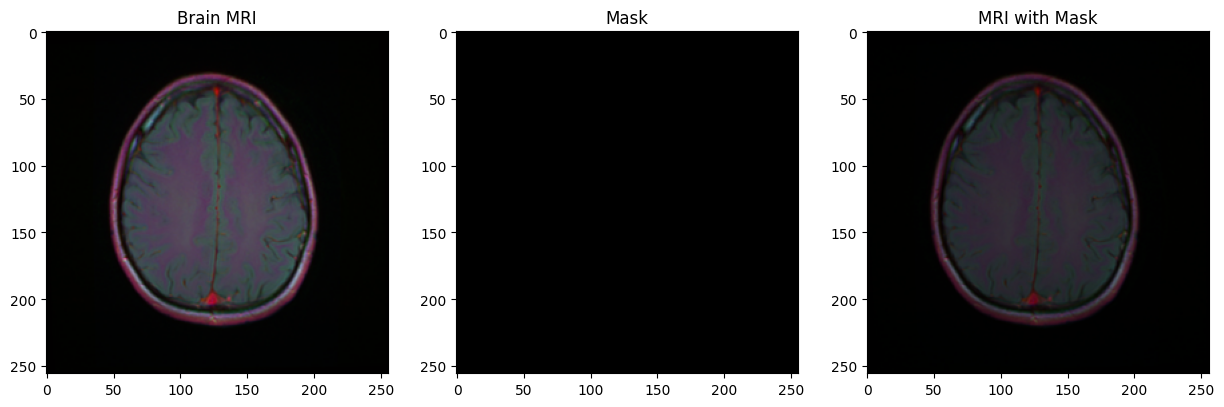

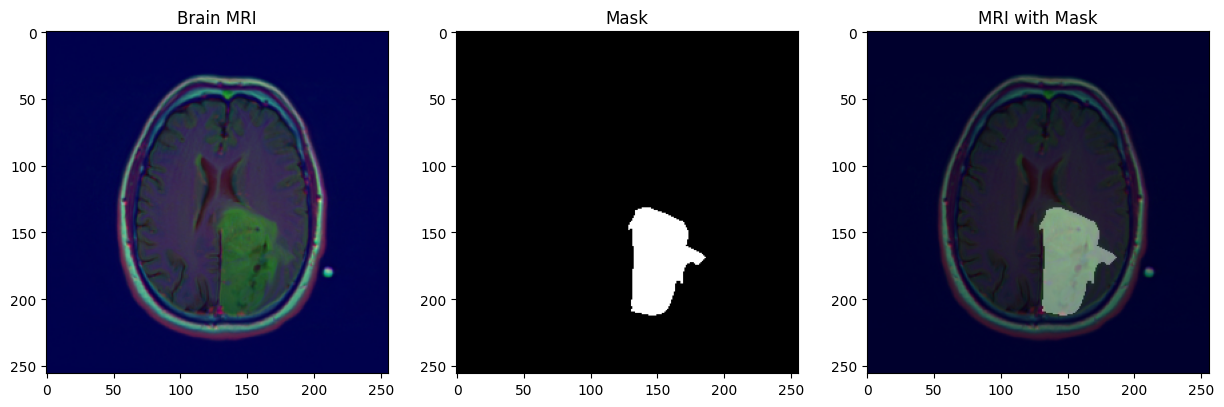

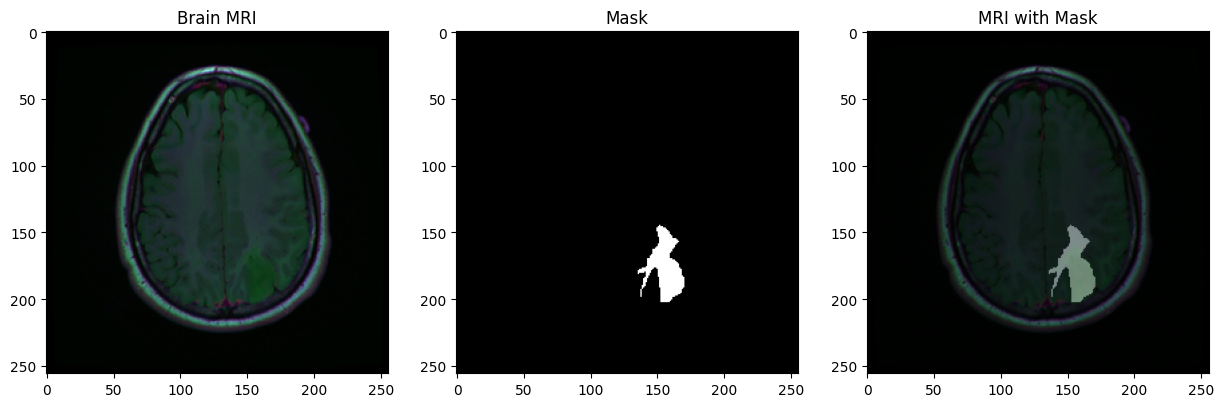

In [ ]:
for i in range(5):
  plot_images()

In [ ]:
image_path=[]
mask_path=[]
def path(i):
  image = os.path.join(data_path,df['Directory'].iloc[i],df['Images'].iloc[i])
  image_path.append(image)
  mask= os.path.join(data_path,df['Directory'].iloc[i],df['Masks'].iloc[i])
  mask_path.append(mask)


In [ ]:
for i in range(len(df)):
  path(i)

In [ ]:
paths = pd.DataFrame({'image_path':image_path,'mask_path':mask_path})

In [ ]:
df = df.join(paths)

In [ ]:
df.head()

,Directory,Images,Masks,image_path,mask_path
0,TCGA_CS_4944_20010208,TCGA_CS_4944_20010208_2.tif,TCGA_CS_4944_20010208_2_mask.tif,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...
1,TCGA_CS_4944_20010208,TCGA_CS_4944_20010208_9.tif,TCGA_CS_4944_20010208_9_mask.tif,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...
2,TCGA_CS_4944_20010208,TCGA_CS_4944_20010208_15.tif,TCGA_CS_4944_20010208_15_mask.tif,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...
3,TCGA_CS_4944_20010208,TCGA_CS_4944_20010208_16.tif,TCGA_CS_4944_20010208_16_mask.tif,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...
4,TCGA_CS_4944_20010208,TCGA_CS_4944_20010208_6.tif,TCGA_CS_4944_20010208_6_mask.tif,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...


In [ ]:
from tqdm import tqdm
a=[]
def pos_neg_diagnosis1(i):
  # mask_path = (os.path.join(data_path,df['Directory'].iloc[i],df['Masks'].iloc[i]))
  boo = np.any(cv2.imread(df['mask_path'].iloc[i]))
  a.append(boo)

In [ ]:
for i in range(len(df)):
  pos_neg_diagnosis1(i)

In [ ]:
a = pd.DataFrame({'diagnosis':a})

In [ ]:
a.head()

,diagnosis
0,False
1,True
2,False
3,False
4,True


In [ ]:
df = df.join(a['diagnosis'])

In [ ]:
df.head()

,Directory,Images,Masks,image_path,mask_path,diagnosis
0,TCGA_CS_4944_20010208,TCGA_CS_4944_20010208_2.tif,TCGA_CS_4944_20010208_2_mask.tif,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,False
1,TCGA_CS_4944_20010208,TCGA_CS_4944_20010208_9.tif,TCGA_CS_4944_20010208_9_mask.tif,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,True
2,TCGA_CS_4944_20010208,TCGA_CS_4944_20010208_15.tif,TCGA_CS_4944_20010208_15_mask.tif,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,False
3,TCGA_CS_4944_20010208,TCGA_CS_4944_20010208_16.tif,TCGA_CS_4944_20010208_16_mask.tif,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,False
4,TCGA_CS_4944_20010208,TCGA_CS_4944_20010208_6.tif,TCGA_CS_4944_20010208_6_mask.tif,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,True


In [ ]:
df['diagnosis'].value_counts()

False    2556
True     1373
Name: diagnosis, dtype: int64

In [ ]:
df['diagnosis'] = df['diagnosis'].apply(lambda x : 1 if x == True else 0)

In [ ]:
df.head()

,Directory,Images,Masks,image_path,mask_path,diagnosis
0,TCGA_CS_4944_20010208,TCGA_CS_4944_20010208_2.tif,TCGA_CS_4944_20010208_2_mask.tif,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,0
1,TCGA_CS_4944_20010208,TCGA_CS_4944_20010208_9.tif,TCGA_CS_4944_20010208_9_mask.tif,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,1
2,TCGA_CS_4944_20010208,TCGA_CS_4944_20010208_15.tif,TCGA_CS_4944_20010208_15_mask.tif,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,0
3,TCGA_CS_4944_20010208,TCGA_CS_4944_20010208_16.tif,TCGA_CS_4944_20010208_16_mask.tif,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,0
4,TCGA_CS_4944_20010208,TCGA_CS_4944_20010208_6.tif,TCGA_CS_4944_20010208_6_mask.tif,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,1


In [ ]:
df['diagnosis'].value_counts()

0    2556
1    1373
Name: diagnosis, dtype: int64

In [ ]:
df1 = df.drop(['Directory','Images','Masks','mask_path'],axis=1)

In [ ]:
df1['diagnosis'] = df1['diagnosis'].apply(lambda x : 'Yes' if x == 1 else 'No')

In [ ]:
df1.head()

,image_path,diagnosis
0,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,No
1,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,Yes
2,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,No
3,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,No
4,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,Yes


### Data Augmentation

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_df, val_df = train_test_split(df1, stratify=df['diagnosis'], test_size=0.1, random_state=0)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

In [ ]:
train_df, test_df = train_test_split(train_df, stratify=train_df['diagnosis'], test_size=0.15, random_state=0)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [ ]:
print(train_df.shape,val_df.shape,test_df.shape)

(3005, 2) (393, 2) (531, 2)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img

In [ ]:
train_data = ImageDataGenerator(
    rotation_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
)

In [ ]:
train_data_generator = train_data.flow_from_dataframe(dataframe = train_df,
                                                      directory = None,
                                                      target_size=(224,224),
                                                      x_col = 'image_path',
                                                      y_col = 'diagnosis',
                                                      batch_size=10,
                                                      class_mode='binary')

Found 3005 validated image filenames belonging to 2 classes.


In [ ]:
val_data = ImageDataGenerator(
    rotation_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

In [ ]:
val_data_generator = val_data.flow_from_dataframe(dataframe = val_df,
                                                      directory = None,
                                                      target_size=(224,224),
                                                      x_col = 'image_path',
                                                      y_col = 'diagnosis',
                                                      batch_size=10,
                                                      class_mode='binary')

Found 393 validated image filenames belonging to 2 classes.


In [ ]:
test_data = ImageDataGenerator(
    rotation_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

In [ ]:
test_data_generator = val_data.flow_from_dataframe(dataframe = test_df,
                                                      directory = None,
                                                      target_size=(224,224),
                                                      x_col = 'image_path',
                                                      y_col = 'diagnosis',
                                                      batch_size=10,
                                                      class_mode='binary')

Found 531 validated image filenames belonging to 2 classes.


##VGG16

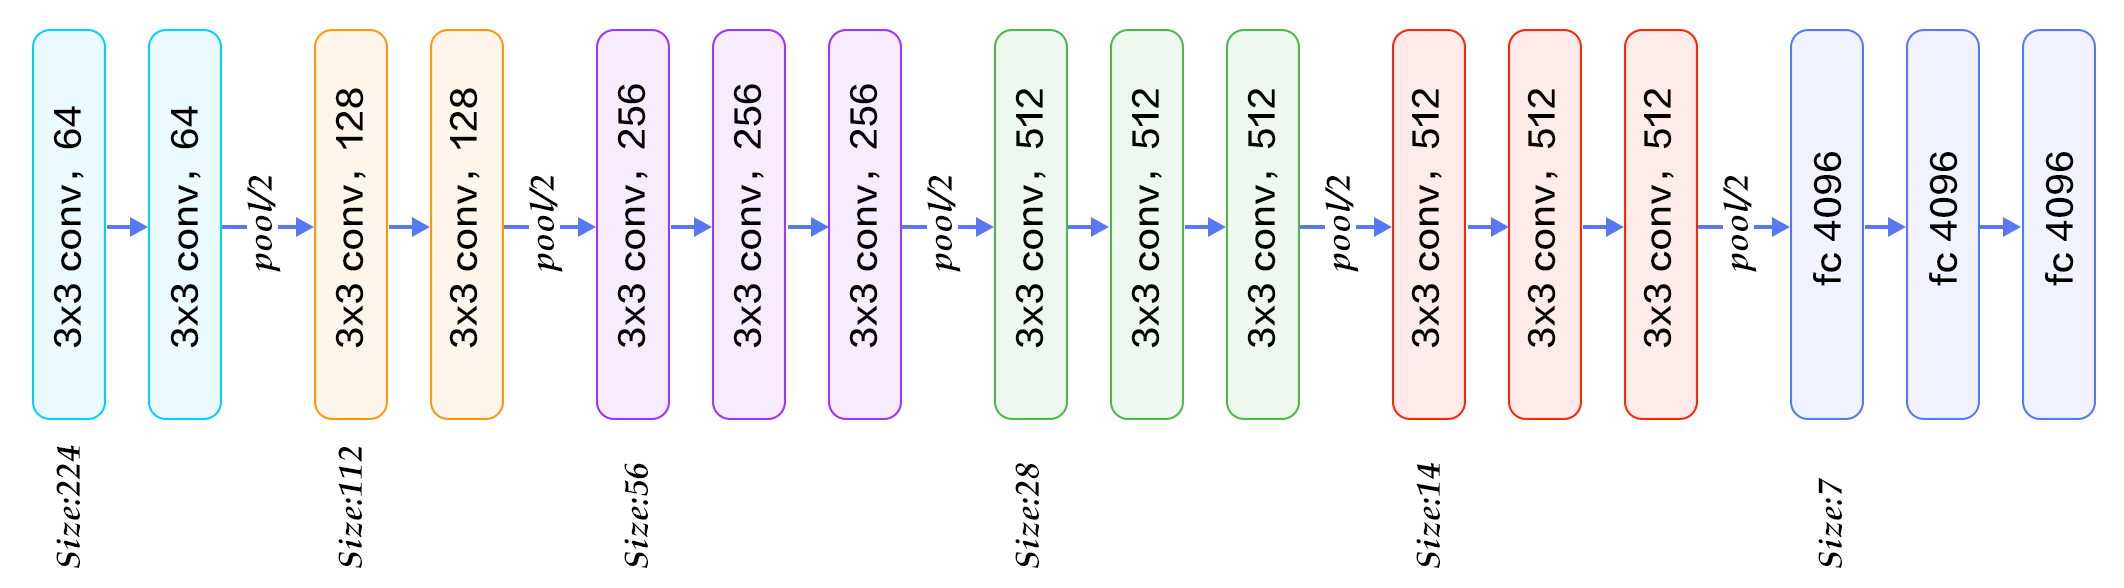

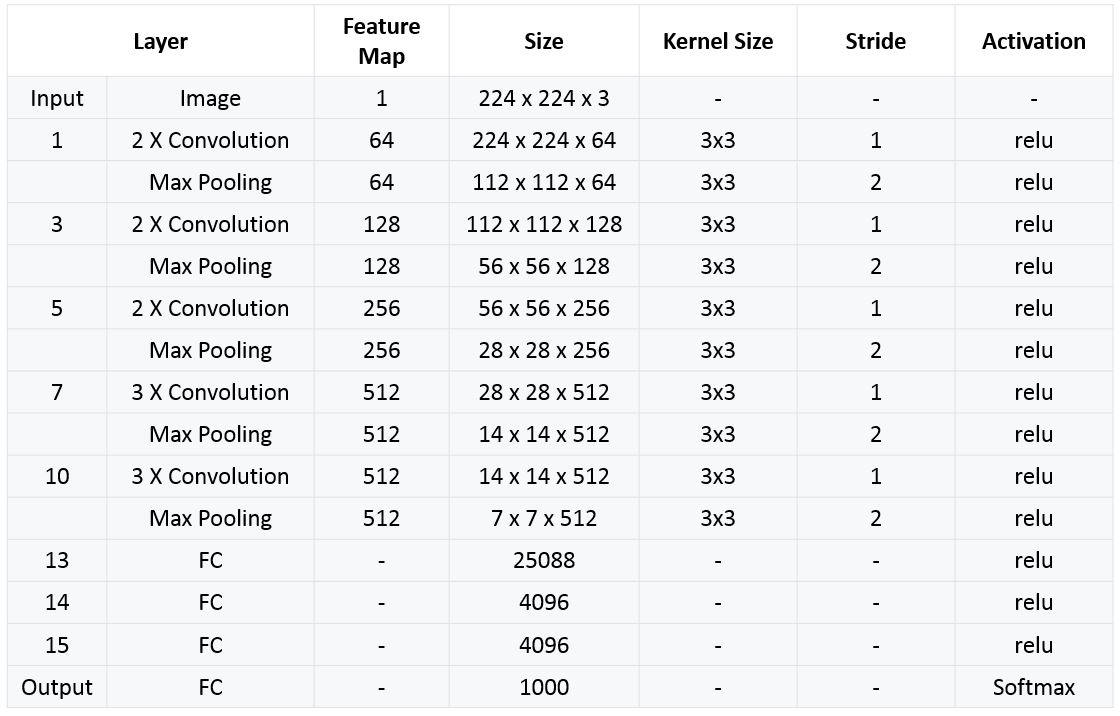

In [ ]:
model = Sequential()

model.add(Conv2D(64,kernel_size=(3,3),padding = 'valid',strides=1,activation='relu',input_shape=(224,224,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3),strides=2,padding = 'valid'))

model.add(Conv2D(128,kernel_size=(3,3),padding = 'valid',strides=1,activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3),strides=2,padding = 'valid'))

model.add(Conv2D(256,kernel_size=(3,3),padding = 'valid',strides=1,activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3),strides=2,padding = 'valid'))

model.add(Conv2D(512,kernel_size=(3,3),padding = 'valid',strides=1,activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3),strides=2,padding = 'valid'))

model.add(Conv2D(512,kernel_size=(3,3),padding = 'valid',strides=1,activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3),strides=2,padding = 'valid'))

model.add(Flatten())

model.add(Dense(25088,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(4096,activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(4096,activation='relu'))
model.add(Dropout(0.65))

model.add(Dense(1,activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 108, 108, 128)     73856     
                                                                 
 batch_normalization_1 (Batc  (None, 108, 108, 128)    512       
 hNormalization)                                                 
                                                        

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
history = model.fit(train_data_generator,validation_data = val_data_generator,epochs=15,batch_size=64)

Epoch 1/15
301/301 [==============================] - 68s 175ms/step - loss: 8.8455 - accuracy: 0.5923 - val_loss: 1.0681 - val_accuracy: 0.6412
Epoch 2/15
301/301 [==============================] - 51s 169ms/step - loss: 0.8868 - accuracy: 0.5930 - val_loss: 0.6670 - val_accuracy: 0.5674
Epoch 3/15
301/301 [==============================] - 51s 170ms/step - loss: 4.2943 - accuracy: 0.5910 - val_loss: 23.1404 - val_accuracy: 0.6514
Epoch 4/15
301/301 [==============================] - 51s 170ms/step - loss: 1.8766 - accuracy: 0.5664 - val_loss: 0.6372 - val_accuracy: 0.6489
Epoch 5/15
301/301 [==============================] - 52s 173ms/step - loss: 0.7402 - accuracy: 0.5940 - val_loss: 0.6160 - val_accuracy: 0.6438
Epoch 6/15
301/301 [==============================] - 51s 169ms/step - loss: 1.1328 - accuracy: 0.6283 - val_loss: 1.0107 - val_accuracy: 0.6107
Epoch 7/15
301/301 [==============================] - 51s 170ms/step - loss: 1.3283 - accuracy: 0.6240 - val_loss: 0.6212 - val_a

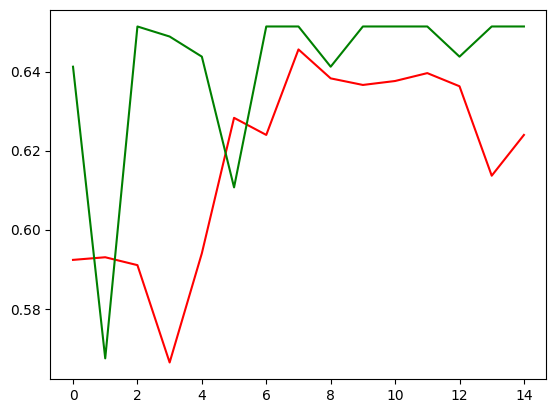

In [ ]:
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='green',label='test')
plt.show()

In [ ]:
model4 = Sequential()

model4.add(Conv2D(64,kernel_size=(3,3),padding = 'valid',strides=1,activation='relu',input_shape=(224,224,3)))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(3,3),strides=2,padding = 'valid'))

model4.add(Conv2D(128,kernel_size=(3,3),padding = 'valid',strides=1,activation='relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(3,3),strides=2,padding = 'valid'))

model4.add(Conv2D(256,kernel_size=(3,3),padding = 'valid',strides=1,activation='relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(3,3),strides=2,padding = 'valid'))

model4.add(Conv2D(256,kernel_size=(3,3),padding = 'valid',strides=1,activation='relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(3,3),strides=2,padding = 'valid'))

model4.add(Conv2D(256,kernel_size=(3,3),padding = 'valid',strides=1,activation='relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(3,3),strides=2,padding = 'valid'))

model4.add(Flatten())


model4.add(Dense(4096,activation='relu'))
model4.add(Dropout(0.4))

model4.add(Dense(4096,activation='relu'))
model4.add(Dropout(0.65))

model4.add(Dense(1,activation='sigmoid'))

In [ ]:
model4.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
history4 = model4.fit(train_data_generator,validation_data = val_data_generator,epochs=15,batch_size=256)

Epoch 1/15
301/301 [==============================] - 43s 141ms/step - loss: 0.4615 - accuracy: 0.7844 - val_loss: 0.4267 - val_accuracy: 0.7939
Epoch 2/15
301/301 [==============================] - 42s 139ms/step - loss: 0.4840 - accuracy: 0.7597 - val_loss: 0.4406 - val_accuracy: 0.8270
Epoch 3/15
301/301 [==============================] - 42s 140ms/step - loss: 0.4822 - accuracy: 0.7894 - val_loss: 0.4385 - val_accuracy: 0.7863
Epoch 4/15
301/301 [==============================] - 43s 141ms/step - loss: 0.4656 - accuracy: 0.7810 - val_loss: 0.4816 - val_accuracy: 0.8142
Epoch 5/15
301/301 [==============================] - 43s 142ms/step - loss: 0.4698 - accuracy: 0.7987 - val_loss: 0.3772 - val_accuracy: 0.8244
Epoch 6/15
301/301 [==============================] - 42s 140ms/step - loss: 0.4597 - accuracy: 0.7894 - val_loss: 0.4948 - val_accuracy: 0.7939
Epoch 7/15
301/301 [==============================] - 44s 145ms/step - loss: 0.4120 - accuracy: 0.8063 - val_loss: 0.3246 - val_ac

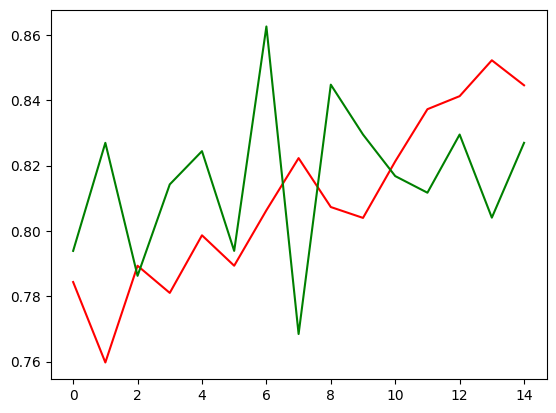

In [ ]:
plt.plot(history4.history['accuracy'],color='red',label='train')
plt.plot(history4.history['val_accuracy'],color='green',label='test')
plt.show()

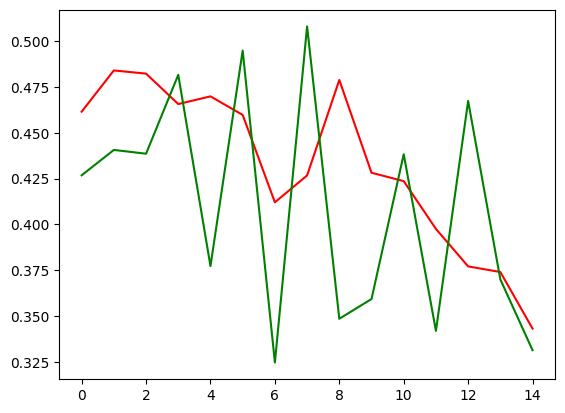

In [ ]:
plt.plot(history4.history['loss'],color='red',label='train')
plt.plot(history4.history['val_loss'],color='green',label='test')
plt.show()

In [ ]:
Prepared many models where which has gven less accuracy and decreaded the complexity for better predictions.
Nedd more computation power to proceed further.